В базе WordNet берем синсет 'search.v.01'. Из всех языков, которые есть в базе, извлекаем списки лемм, относящихся к этому синсету.

In [1]:
import nltk
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='nltk')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
exemplar = wn.synset('search.v.01')
y = exemplar.lemma_names("fra")
d = dict()
for x in wn.langs():
    if x:
        d[x] = exemplar.lemma_names(x)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Для каждой леммы из каждого языка составляем список синсетов, к которым она относится. Из этих синсетов выбираем такие, к которым относится больше 3 лемм из нашего изначального списка.

In [2]:
from collections import Counter
synsets_for_lemmas = {}
for lang in d:
    for word in d[lang]:
        synsets = wn.synsets(word, lang=lang)
        synsets_for_lemmas[word] = synsets
all_synsets_counter = Counter()
for value_list in synsets_for_lemmas.values():
    all_synsets_counter.update(value_list)
filtered_synsets_for_lemmas = {
    key: [word for word in value_list if all_synsets_counter[word] >= 3]
    for key, value_list in synsets_for_lemmas.items()
}

Строим ребра и визуализируем граф.

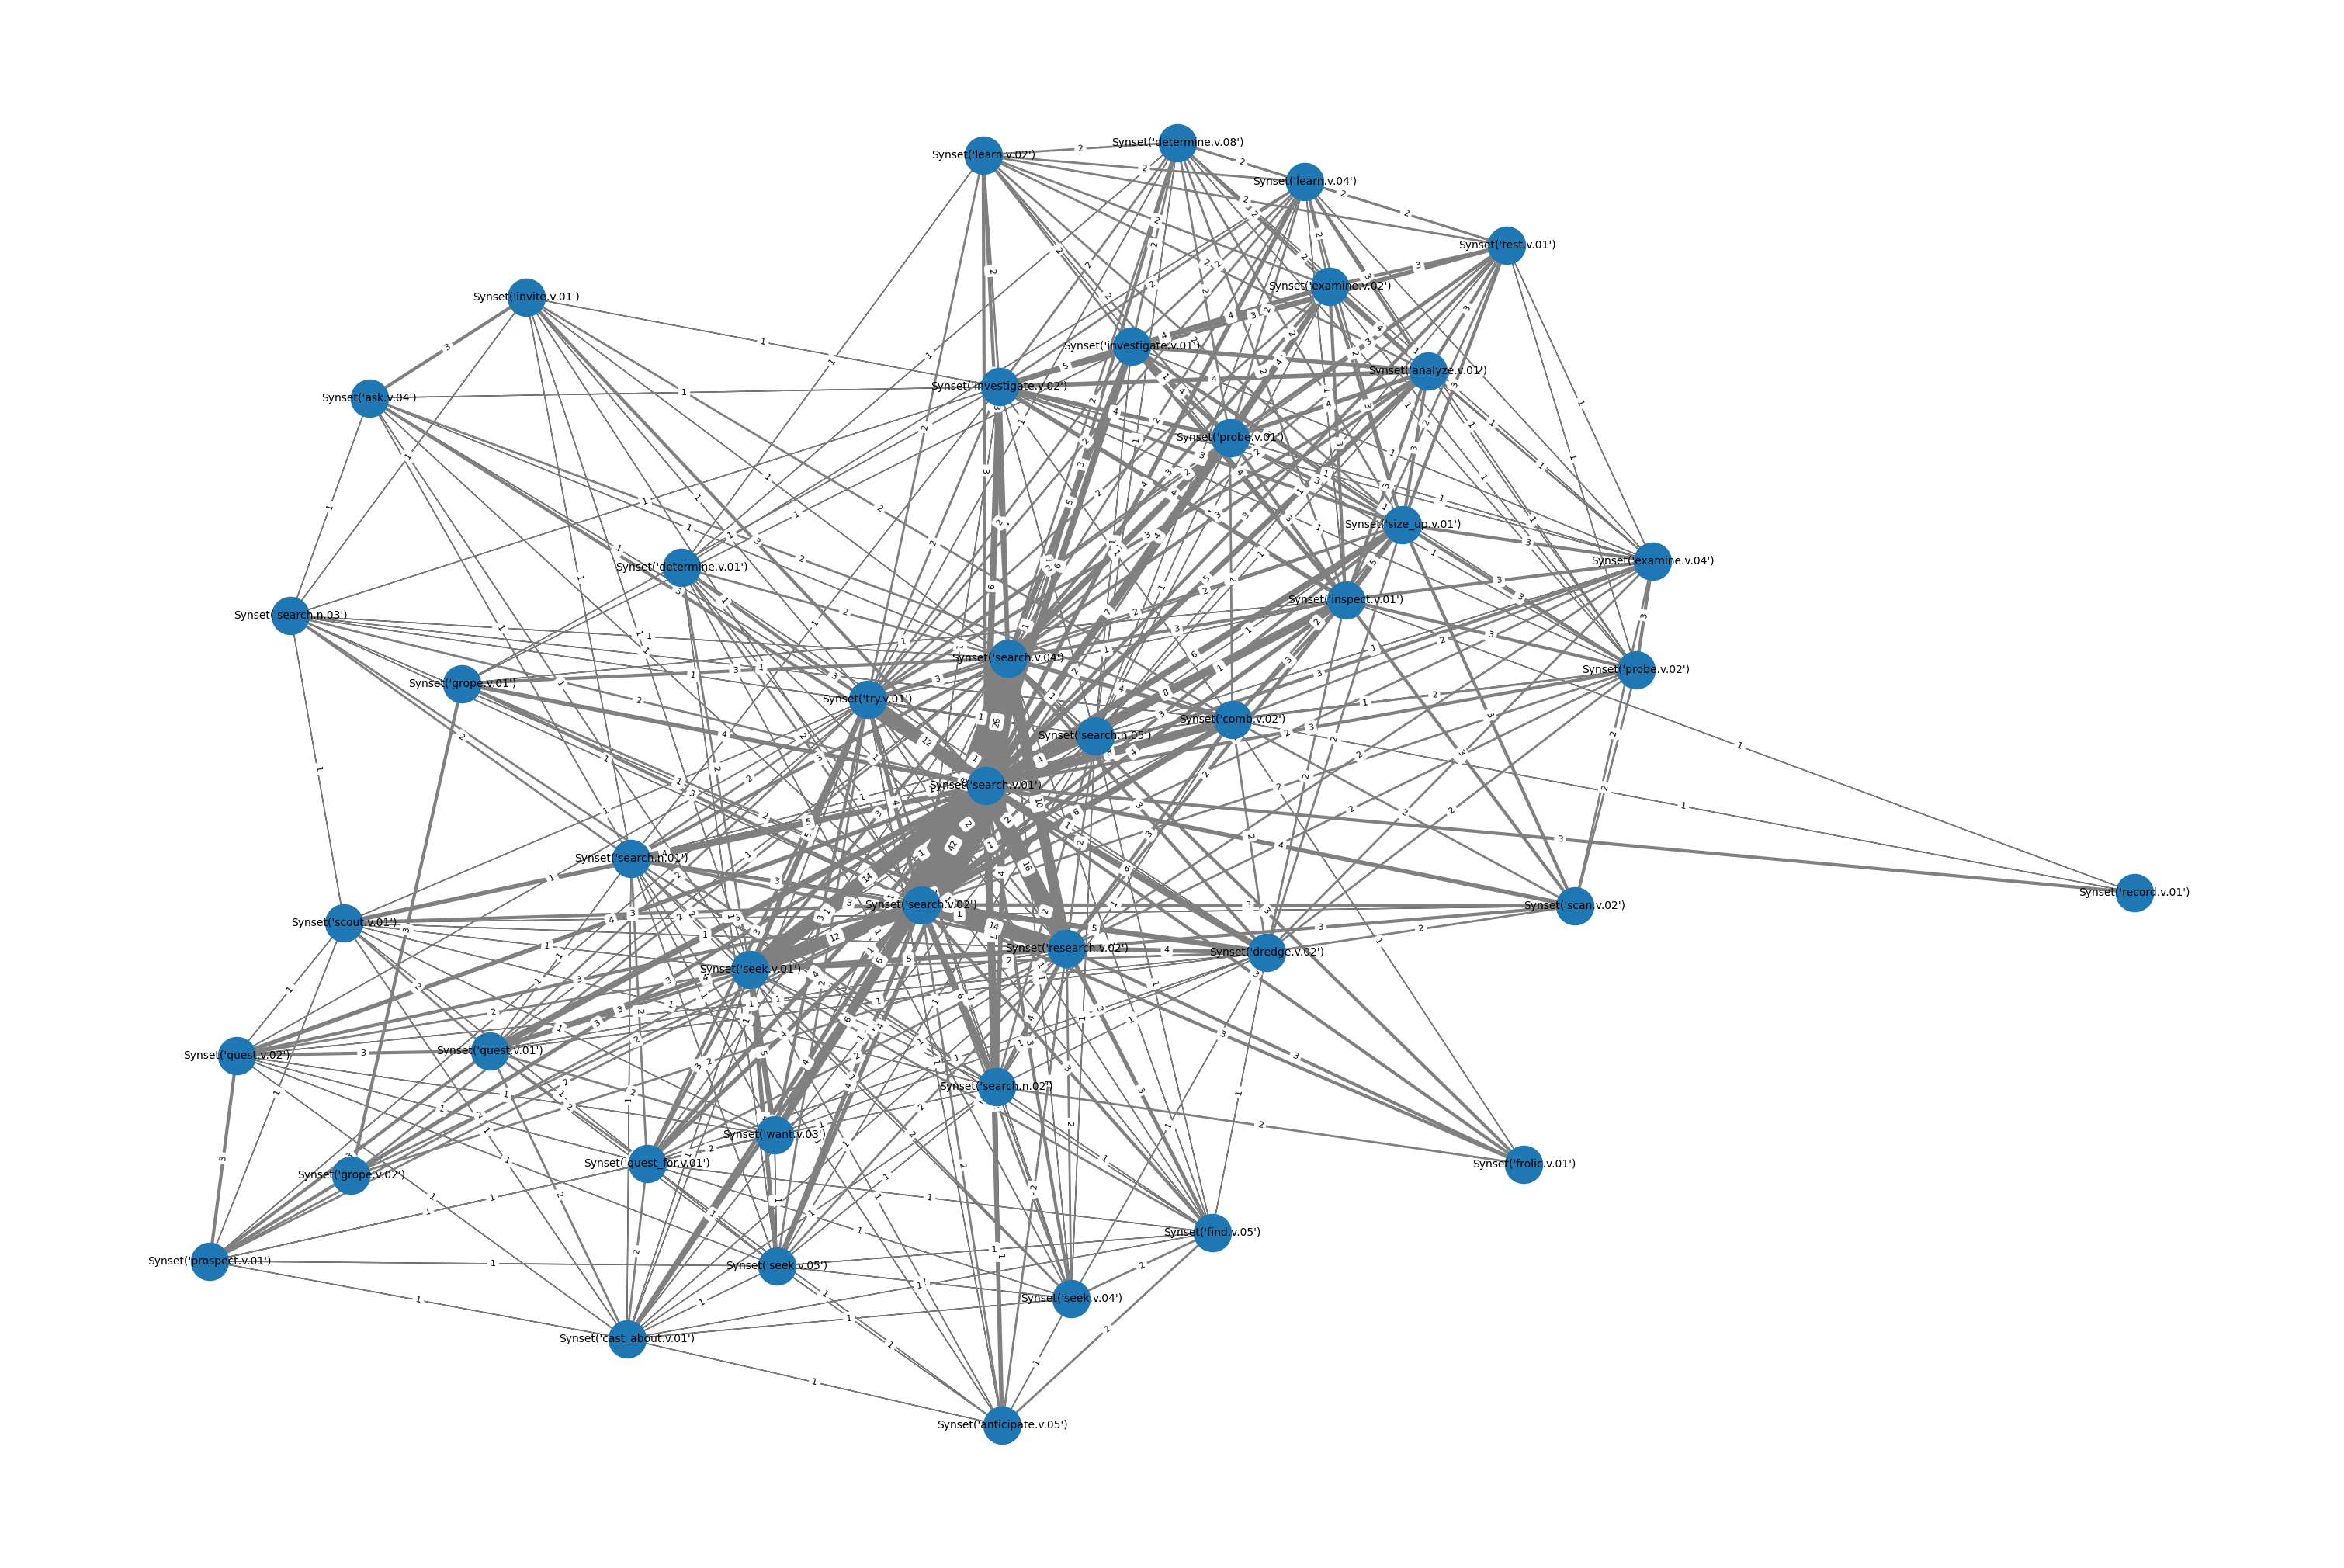

In [3]:
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

# Создаем словарь, где ключ - пара Synset'ов, а значение - вес ребра
edge_weights = defaultdict(int)

# Итерируемся по ключам словаря
for key, synsets in filtered_synsets_for_lemmas.items():
    # Создаем все возможные пары Synset'ов
    for i in range(len(synsets)):
        for j in range(i+1, len(synsets)):
            pair = (synsets[i], synsets[j])
            # Увеличиваем вес ребра на 1
            edge_weights[pair] += 1

# Создаем граф
G = nx.Graph()

# Добавляем узлы
for key, synsets in filtered_synsets_for_lemmas.items():
    for synset in synsets:
        G.add_node(synset)

# Добавляем ребра с весами
for pair, weight in edge_weights.items():
    G.add_edge(pair[0], pair[1], weight=weight)

# Визуализируем граф
pos = nx.spring_layout(G, k=0.5, scale=2)
plt.figure(figsize=(30, 20))
nx.draw(G, pos, with_labels=True, node_size=1200, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='grey', width=[d['weight'] for (u, v, d) in G.edges(data=True)])

# Добавляем значение веса на ребра
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.show()


Проанализируем полученный граф:




1. Выделим связные компоненты, посмотим на их количество.

In [4]:
components = nx.components.connected_components(G)
print(len(sorted(components)))

1


При таком условии постановке ребёр граф состоит из одной связной компоненты.

Теперь вычислим плотность графа.

In [5]:
nx.density(G)

0.4143763213530655

Посмотрим на распределение взвешенных степеней узлов.

<ipython-input-6-813e9a0367b0>:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


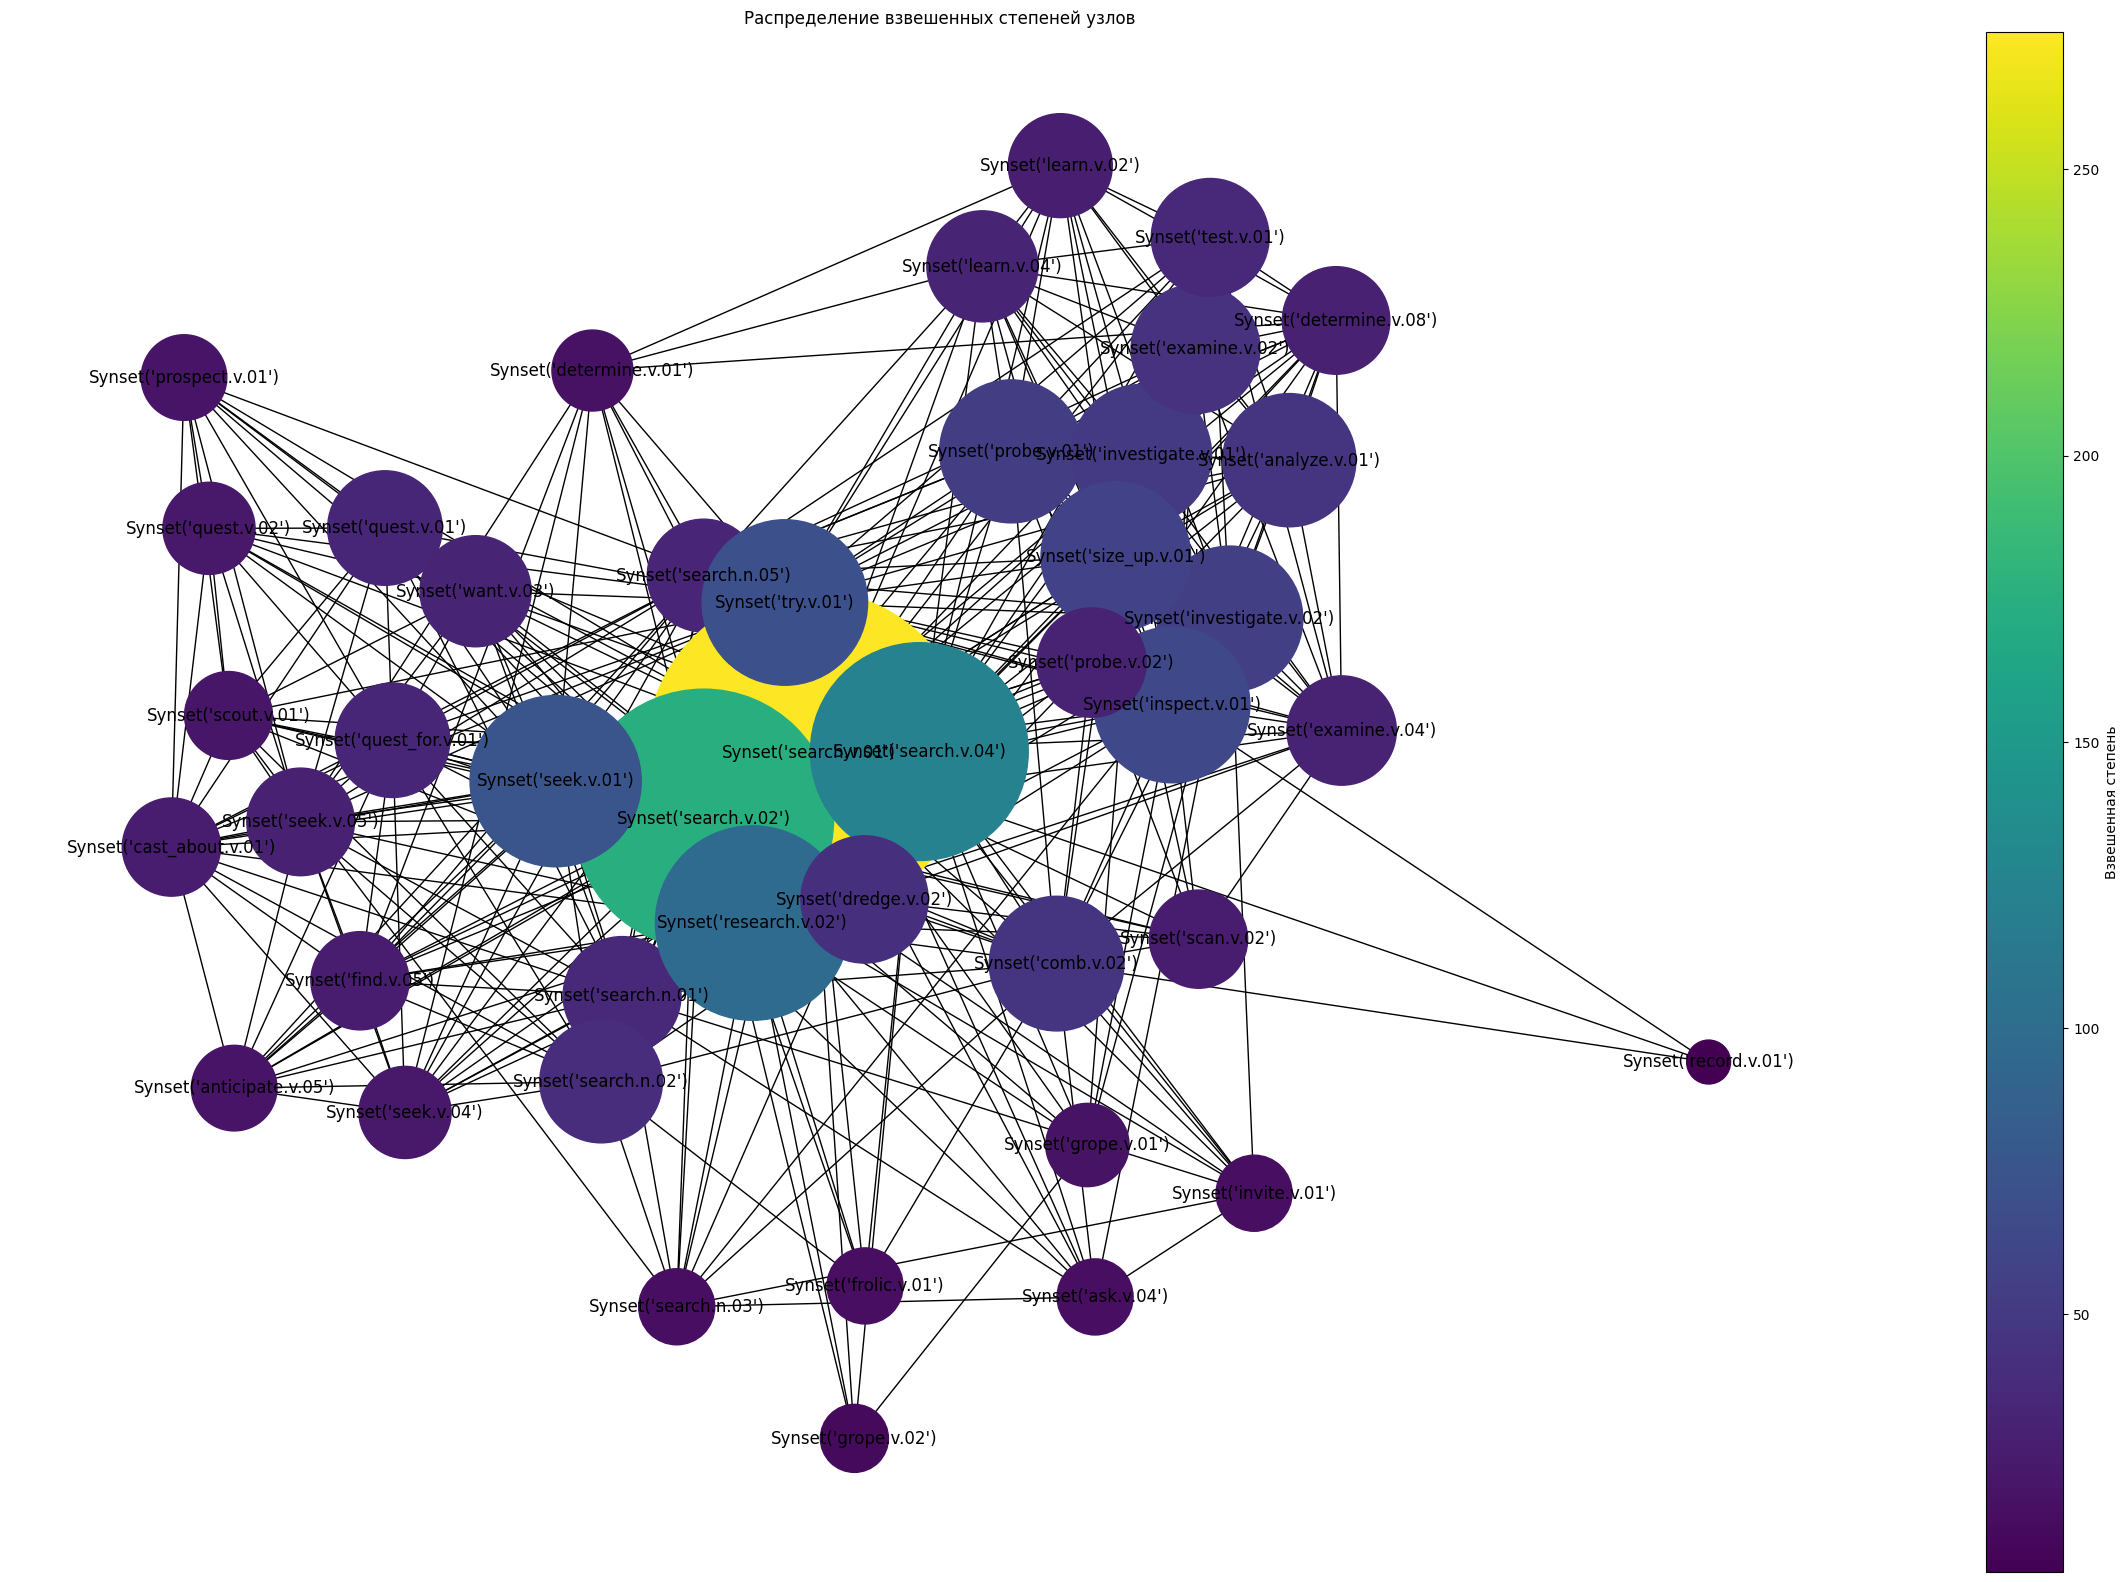

In [6]:
# Вычисляем взвешенные степени узлов
weighted_degrees = dict(G.degree(weight='weight'))

# Визуализируем распределение степеней
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(30, 20))

# Рисуем узлы
nodes = nx.draw_networkx_nodes(G, pos,
                               node_color=list(weighted_degrees.values()),
                               cmap='viridis',
                               node_size=[v*200 for v in weighted_degrees.values()])

# Рисуем ребра
edges = nx.draw_networkx_edges(G, pos)

# Рисуем метки
labels = nx.draw_networkx_labels(G, pos)

# Добавляем цветовую шкалу
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(weighted_degrees.values()), vmax=max(weighted_degrees.values())))
cbar = fig.colorbar(sm)
cbar.set_label('Взвешенная степень')

# Настраиваем отображение
ax.set_title('Распределение взвешенных степеней узлов')
ax.axis('off')
plt.show()

Теперь посмотрим на топ-10 центральных узлов по мерам degree centrality, closeness centrality, betweenness centrality и eigencentrality.

In [10]:
# Центральность по степени (degree centrality)
print("Топ-10 узлов по мере degree centrality - имеющих наибольшее количество связей")
deg = nx.degree_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

# Центральность по близости (betweenness centrality)
print("Топ-10 узлов по мере betweenness_centrality - являющихся составляющими наибольшего количества кратчайших путей")
deg = nx.betweenness_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

# Центральность по посредничеству (eigenvector centrality)
print("Топ-10 узлов по мере eigencentrality - имеющих связи с узлами, имеющих наибольшее количество связей")
deg = nx.eigenvector_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)


# Центральность по собственному вектору (closeness centrality)
print("Топ-10 узлов по мере closeness centralit - имеющих наиболее короткие пути до других узлов")
deg = nx.closeness_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

Топ-10 узлов по мере degree centrality - имеющих наибольшее количетсво связей
Synset('search.v.01')
Synset('search.v.02')
Synset('search.v.04')
Synset('try.v.01')
Synset('research.v.02')
Synset('search.n.05')
Synset('seek.v.01')
Synset('investigate.v.02')
Synset('inspect.v.01')
Synset('search.n.01')
Топ-10 узлов по мере betweenness_centrality - являющихся составляющими наибольшего количества кратчайших путей
Synset('search.v.01')
Synset('search.v.02')
Synset('try.v.01')
Synset('search.v.04')
Synset('research.v.02')
Synset('search.n.05')
Synset('comb.v.02')
Synset('inspect.v.01')
Synset('investigate.v.02')
Synset('seek.v.01')
Топ-10 узлов по мере eigencentrality - имеющих связи с узлами, имеющих наибольшее количество связей
Synset('search.v.01')
Synset('search.v.02')
Synset('try.v.01')
Synset('search.v.04')
Synset('search.n.05')
Synset('research.v.02')
Synset('seek.v.01')
Synset('inspect.v.01')
Synset('search.n.01')
Synset('investigate.v.02')
Топ-10 узлов по мере closeness centralit - и

Видно, что по разным мерам наиболее центральными оказались приблизительно одни и те же синсеты (Synset('search.v.01'), Synset('search.v.02'), Synset('search.v.04'), Synset('try.v.01'), Synset('search.n.05')  и др.), однако есть различия как в их порядке, так и в составе: например, по мере betweenness_centrality центральным является узел Synset('comb.v.02'). Это связано с различиями в методах подсчета.

Теперь несколькими способами разобъем граф на сообщества.

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пример графа
G = nx.karate_club_graph()

# Разбиваем граф на сообщества с помощью разных алгоритмов
print("Разбиение графа на сообщества:")

# Алгоритм Лувена (Louvain)
louvain_communities = nx.community.louvain_communities(G)
print("Лувен (Louvain):")
print(louvain_communities)

# Алгоритм Гирвана-Ньюмена (Girvan-Newman)
girvan_newman_communities = nx.community.girvan_newman(G)
print("\nГирвана-Ньюмена (Girvan-Newman):")
print(list(girvan_newman_communities))

# Алгоритм Label Propagation
label_prop_communities = nx.community.label_propagation_communities(G)
print("\nLabel Propagation:")
print(list(label_prop_communities))



Разбиение графа на сообщества:
Лувен (Louvain):
[{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {16, 4, 5, 6, 10}, {23, 24, 25, 27, 28, 31}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}]

Гирвана-Ньюмена (Girvan-Newman):
[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18,

Алгоритм Лувена и Label Propagation показали примерно одинаковые результаты, выделив 3 и 4 сообщества соответсвенно, в то время как алгоритм Гирвана-Ньюмена, направленный на выявление иерархических структур, выделил более сложную вложенную систему.

Теперь на этих же данных построим и проанализируем новый граф, оставив более устойчивые связи.

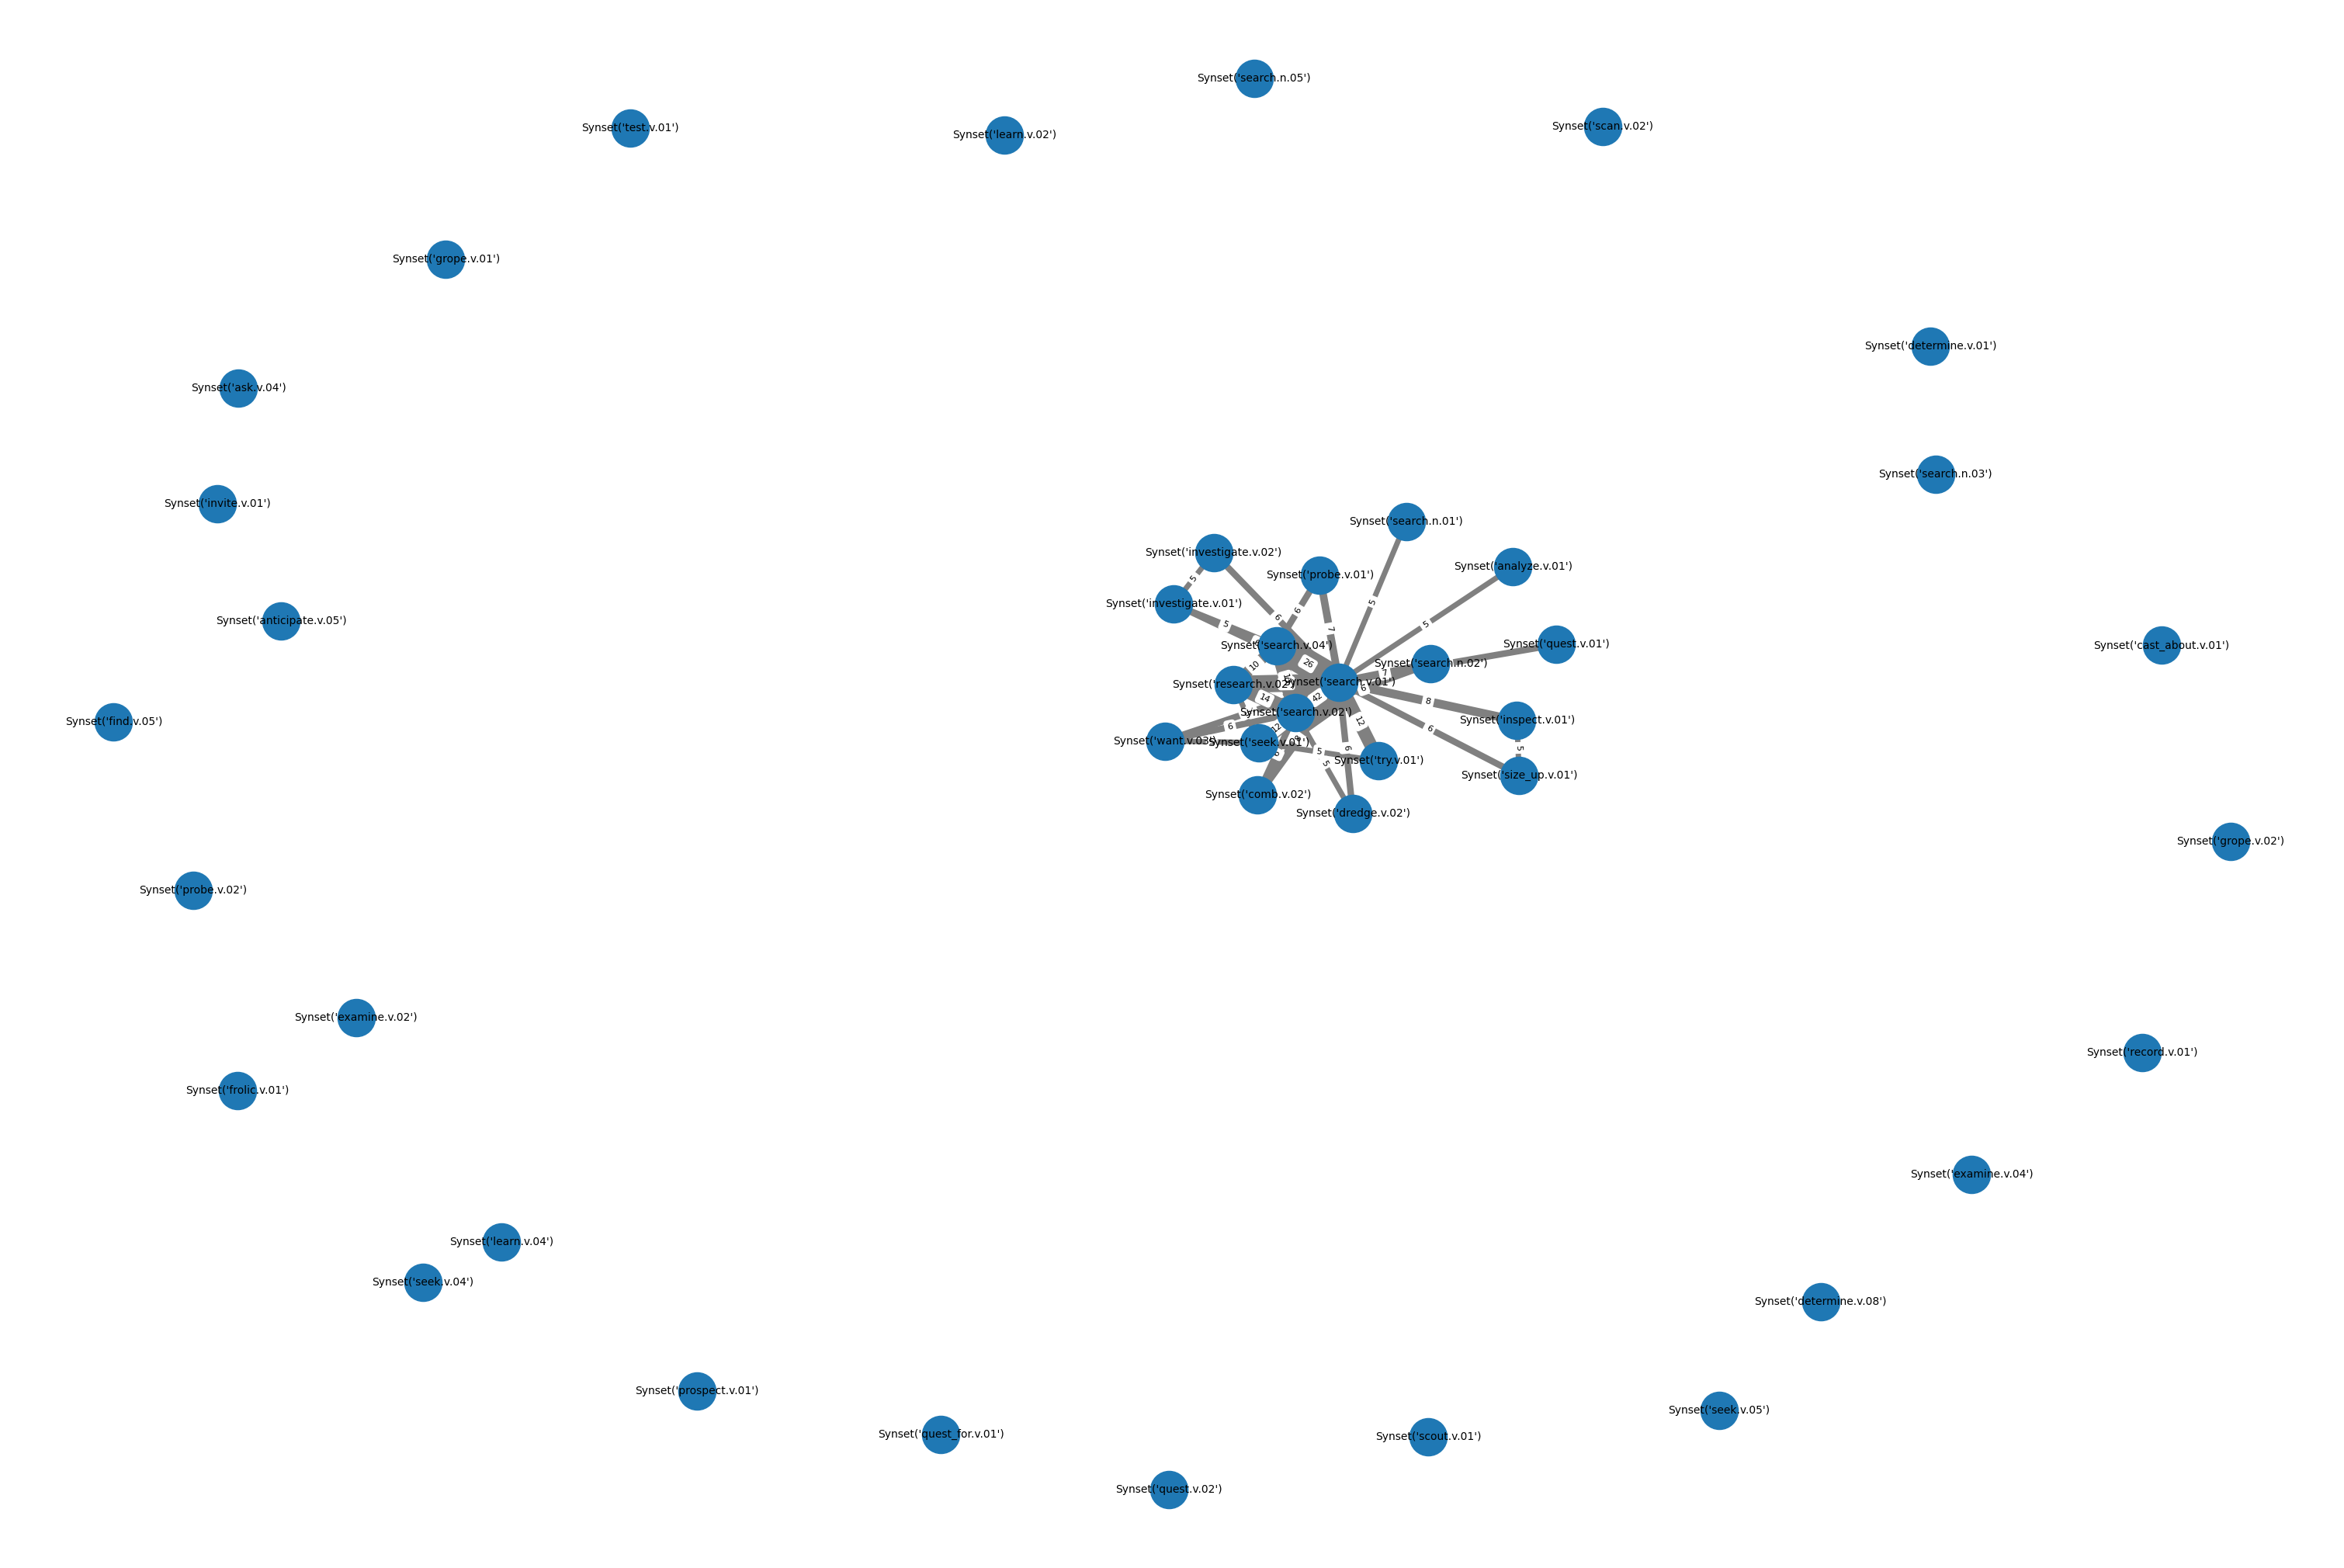

In [24]:
# Создаем словарь, где ключ - пара Synset'ов, а значение - вес ребра
edge_weights = defaultdict(int)

# Итерируемся по ключам словаря
for key, synsets in filtered_synsets_for_lemmas.items():
    # Создаем все возможные пары Synset'ов
    for i in range(len(synsets)):
        for j in range(i+1, len(synsets)):
            pair = (synsets[i], synsets[j])
            # Увеличиваем вес ребра на 1
            edge_weights[pair] += 1

# Создаем граф
G = nx.Graph()

# Добавляем узлы
for key, synsets in filtered_synsets_for_lemmas.items():
    for synset in synsets:
        G.add_node(synset)

# Добавляем ребра с весами
for pair, weight in edge_weights.items():
    if weight >= 5:
        G.add_edge(pair[0], pair[1], weight=weight)

# Визуализируем граф
pos = nx.spring_layout(G, k=0.5, scale=2)
plt.figure(figsize=(30, 20))
nx.draw(G, pos, with_labels=True, node_size=1200, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='grey', width=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] >= 5])

# Добавляем значение веса на ребра
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True) if d['weight'] >= 5}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.show()


In [25]:
components = nx.components.connected_components(G)
print(len(sorted(components)))

27


При таком условии построения ребер граф состоит из 27 связных компонент.

In [26]:
nx.density(G)

0.03382663847780127

Плотность этого графа заметно ниже, чем у первого.

<ipython-input-27-813e9a0367b0>:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


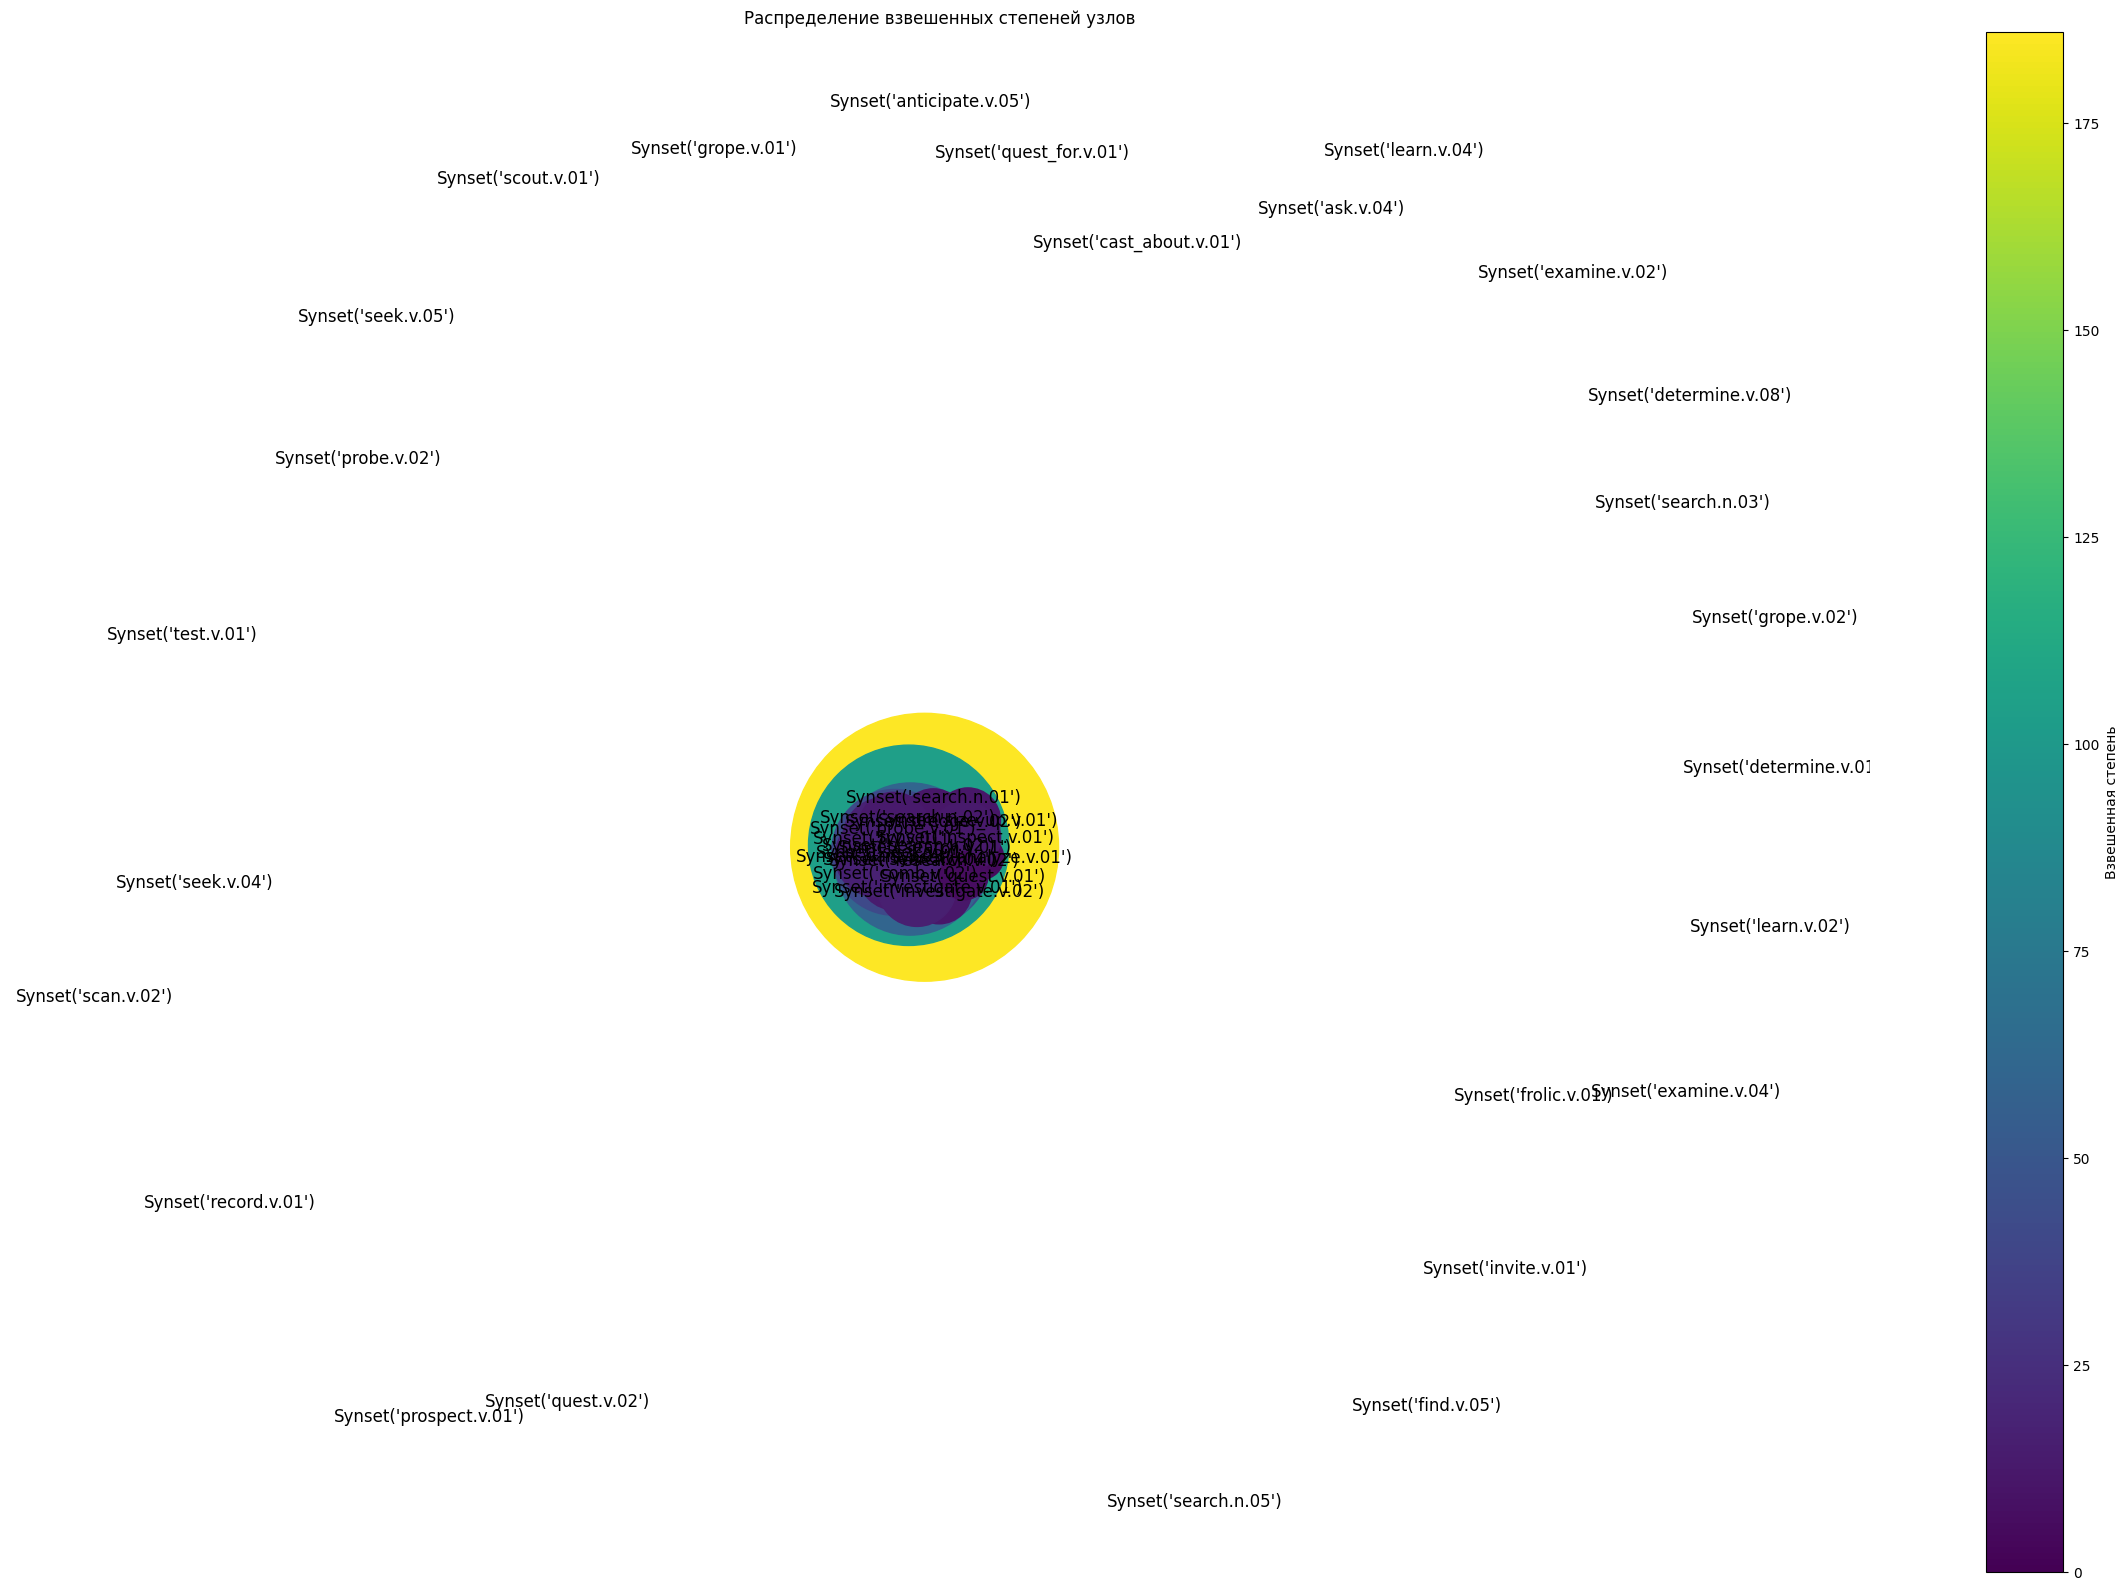

In [27]:
# Вычисляем взвешенные степени узлов
weighted_degrees = dict(G.degree(weight='weight'))

# Визуализируем распределение степеней
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(30, 20))

# Рисуем узлы
nodes = nx.draw_networkx_nodes(G, pos,
                               node_color=list(weighted_degrees.values()),
                               cmap='viridis',
                               node_size=[v*200 for v in weighted_degrees.values()])

# Рисуем ребра
edges = nx.draw_networkx_edges(G, pos)

# Рисуем метки
labels = nx.draw_networkx_labels(G, pos)

# Добавляем цветовую шкалу
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(weighted_degrees.values()), vmax=max(weighted_degrees.values())))
cbar = fig.colorbar(sm)
cbar.set_label('Взвешенная степень')

# Настраиваем отображение
ax.set_title('Распределение взвешенных степеней узлов')
ax.axis('off')
plt.show()

Визуализация взвешенных степеней узлов нового графа позволяет выделить более значимые синсеты.

In [28]:
# Центральность по степени (degree centrality)
print("Топ-10 узлов по мере degree centrality - имеющих наибольшее количество связей")
deg = nx.degree_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

# Центральность по близости (betweenness centrality)
print("Топ-10 узлов по мере betweenness_centrality - являющихся составляющими наибольшего количества кратчайших путей")
deg = nx.betweenness_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

# Центральность по посредничеству (eigenvector centrality)
print("Топ-10 узлов по мере eigencentrality - имеющих связи с узлами, имеющих наибольшее количество связей")
deg = nx.eigenvector_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)


# Центральность по собственному вектору (closeness centrality)
print("Топ-10 узлов по мере closeness centrality - имеющих наиболее короткие пути до других узлов")
deg = nx.closeness_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
    print(nodeid)

Топ-10 узлов по мере degree centrality - имеющих наибольшее количество связей
Synset('search.v.01')
Synset('search.v.02')
Synset('search.v.04')
Synset('seek.v.01')
Synset('research.v.02')
Synset('investigate.v.01')
Synset('want.v.03')
Synset('search.n.02')
Synset('try.v.01')
Synset('dredge.v.02')
Топ-10 узлов по мере betweenness_centrality - являющихся составляющими наибольшего количества кратчайших путей
Synset('search.v.01')
Synset('search.v.02')
Synset('search.v.04')
Synset('seek.v.01')
Synset('investigate.v.01')
Synset('research.v.02')
Synset('search.n.01')
Synset('search.n.02')
Synset('search.n.03')
Synset('search.n.05')
Топ-10 узлов по мере eigencentrality - имеющих связи с узлами, имеющих наибольшее количество связей
Synset('search.v.01')
Synset('search.v.02')
Synset('seek.v.01')
Synset('search.v.04')
Synset('research.v.02')
Synset('want.v.03')
Synset('investigate.v.01')
Synset('search.n.02')
Synset('dredge.v.02')
Synset('comb.v.02')
Топ-10 узлов по мере closeness centralit - им

Интересно, что в графе с более значимыми связями сразу по нескольким мерам центральности выделены синсеты Synset('want.v.03') и Synset('dredge.v.02'), которые не вошли в топ-10 наиболее центральных узлов первого графа.

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем пример графа
G = nx.karate_club_graph()

# Разбиваем граф на сообщества с помощью разных алгоритмов
print("Разбиение графа на сообщества:")

# Алгоритм Лувена (Louvain)
louvain_communities = nx.community.louvain_communities(G)
print("Лувен (Louvain):")
print(louvain_communities)

# Алгоритм Гирвана-Ньюмена (Girvan-Newman)
girvan_newman_communities = nx.community.girvan_newman(G)
print("\nГирвана-Ньюмена (Girvan-Newman):")
print(list(girvan_newman_communities))

# Алгоритм Label Propagation
label_prop_communities = nx.community.label_propagation_communities(G)
print("\nLabel Propagation:")
print(list(label_prop_communities))



Разбиение графа на сообщества:
Лувен (Louvain):
[{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {16, 4, 5, 6, 10}, {23, 24, 25, 27, 28, 31}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}]

Гирвана-Ньюмена (Girvan-Newman):
[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18,

Как и в предыдущем случае, алгоритм Лувена и Label Propagation показали схожие результаты, выделив 3 и 4 сообщества, в то время как алгоритм Гирвана-Ньюмена, направленный на выявление иерархических структур, выделил более сложную вложенную систему.

После удаления ребер с небольшим весом стали заметны более устойчивые закономерности, поэтому граф, при построении которого был установлен порог в не менее 5 общих лемм для пары синсетов, более информативен.

Как видно из выделенных кластеров, глаголы поиска семантически связаны с глаголами, указывающими на физические действия, связанные с процессом познания, с глаголами, отражающими желание, намерение или потребность познать что-либо, а также с глаголами, характеризующими более абстрактные аспекты познавательной активности - наличие второй из этих групп наиболее заметно при нализе графа, отражающего более устойчивые закономерности.